In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pydicom
import cv2
from math import ceil
# import json

# from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

# from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import matplotlib.pyplot as plt
import seaborn as sns

# from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df, process_image
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, get_master_df, mask_image
from process import process_image

In [12]:
ddsm_df = get_ddsm_table("../../DDSM")
INbreast_df = get_INBreast_table("../../INbreast Release 1.0")
vindr_df = get_VinDR_table("../../VinDr")
master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

In [3]:
master_df.replace({'breast_density': {'DENSITY A': 1, 'DENSITY B': 2, 'DENSITY C': 3, 'DENSITY D': 4}}, inplace=True)
master_df['breast_density'] = pd.to_numeric(master_df['breast_density'], errors='coerce')
master_df.dropna(subset=['breast_density'], inplace=True)
master_df['breast_density'] = master_df['breast_density'] - 1
# master_df = master_df.groupby('breast_density').sample(n=200)

In [5]:
def load_image(row, process):
    image_size = (650,400)
    dicom_path = row["full_path"]
    vendor = row["Manufacturer"]
    dicom_data = pydicom.dcmread(dicom_path)
    image = dicom_data.pixel_array
    image = mask_image(image)
    
    if process:
        image = process_image(image, vendor) # custom processing

    image = (image - np.mean(image))/np.std(image)
    image = cv2.resize(image, image_size)
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=3)
    return image

In [6]:
def data_generator(df, batch_size, process=False):
    num_samples = len(df)
    image_size = (650,400)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            
            for _, row in batch_df.iterrows():
                dicom_path = row["full_path"]
                label = row["breast_density"]
                vendor = row["Manufacturer"]
                dicom_data = pydicom.dcmread(dicom_path)
                image = dicom_data.pixel_array
                image = mask_image(image)
                
                if process:
                    image = process_image(image, vendor) # custom processing

                image = (image - np.mean(image))/np.std(image)
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(label)
            
            # Convert to numpy arrays
            images = np.array(images).reshape(-1, 1, *image_size)  # Add channel dimension
            labels = np.array(labels)
            
            images = torch.tensor(images, dtype=torch.float32).to('cuda')
            labels = torch.tensor(labels, dtype=torch.long).to('cuda')
            yield images, labels

In [ ]:
# only uncomment if data balancing should be done

# ros = RandomOverSampler()
# x, y = ros.fit_resample(master_df.drop(columns=['breast_density']), master_df['breast_density'])
# x['breast_density'] = y
# master_df = x

<H3> This part runs with model.py (our custom model) </H3>

In [8]:
batch_size = 32

train_df, temp_df = train_test_split(master_df, test_size=0.3)
val_df, test_df = train_test_split(temp_df, test_size=0.5)

# Create generators
train_gen = data_generator(train_df, batch_size, True)
val_gen = data_generator(val_df, batch_size, True)
test_gen = data_generator(test_df, batch_size, True)

# # Get the number of steps per epoch
train_steps = ceil(len(train_df) // batch_size)
val_steps = ceil(len(val_df) // batch_size)
test_steps = ceil(len(test_df) // batch_size)
print(train_steps, val_steps, test_steps)


158 33 33


In [9]:
def train_model(model, optimizer, train_steps, val_steps, epochs, batch_size):
    train_losses = []
    train_accuracies = []
    train_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 10

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_f1 = 0, 0, 0
        for _ in tqdm(range(train_steps), desc='Training batch'):
            images, labels = next(train_gen)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += (preds == labels).sum().item()
            train_f1 += f1_score(labels.cpu(), preds.cpu(), average='weighted')

        train_loss /= train_steps
        train_acc /= (train_steps*batch_size)
        train_f1 /= train_steps
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)

        # Validation phase
        model.eval()
        val_loss, val_acc, val_f1 = 0, 0, 0
        with torch.no_grad():
            for _ in tqdm(range(val_steps), desc='Validation batch'):
                images, labels = next(val_gen)         
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate metrics
                preds = torch.argmax(outputs, dim=1)
                val_loss += loss.item()
                val_acc += (preds == labels).sum().item()
                val_f1 += f1_score(labels.cpu(), preds.cpu(), average='weighted')

        val_loss /= val_steps
        val_acc /= (val_steps*batch_size)
        val_f1 /= val_steps
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc:.4f} | Validation F1: {val_f1:.4f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

    return (train_losses, train_accuracies, train_f1_scores, val_losses, val_accuracies, val_f1_scores)

In [10]:
from model import BaselineBreastModel as CNNModel
model = CNNModel(device='cuda', nodropout_probability=1, gaussian_noise_std=0)
model = model.to('cuda')

In [11]:
def initialize_weights_he_uniform(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

model.apply(initialize_weights_he_uniform)

BaselineBreastModel(
  (_conv_layer_ls): ModuleList(
    (0): SimpleConvLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    )
    (1): SimpleConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    )
    (2-3): 2 x SimpleConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (4): SimpleConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (5-9): 5 x SimpleConvLayer(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (10): SimpleConvLayer(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    )
    (11-12): 2 x SimpleConvLayer(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    )
  )
  (all_views_pad): SimplePad()
  (all_views_max_pool): SimpleMaxPool()
  (all_views_avg_pool): SimpleAvgPool()
  (fc1): Linear(in_features=19584, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
  (gaus

In [12]:
metrics = train_model(model, optimizer=optim.Adam(model.parameters(), lr=0.0001), 
                      train_steps=train_steps, val_steps=val_steps, 
                      epochs=100, batch_size=32)

Validation batch: 100%|██████████| 33/33 [04:13<00:00,  7.68s/it]


Epoch 1/100 | Train Loss: 1.4907 | Train Acc: 0.2530 | Train F1: 0.1075
Validation Loss: 1.4956 | Validation Acc: 0.2481 | Validation F1: 0.1039


Training batch:   6%|▋         | 10/158 [01:10<17:24,  7.05s/it]


KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(), 'model.pth')
torch.save(model, 'model_full.pth')

<H3> Runs with the prebuilt model from the GitHub Repo </H3>

In [14]:
import models_torch as models

In [10]:
model = models.BaselineBreastModel('cuda', nodropout_probability=1.0, gaussian_noise_std=0.0).to('cuda')
model.load_state_dict(torch.load('model.p'))

<All keys matched successfully>

In [11]:
df = master_df[master_df['Manufacturer'].isin(['SIEMENS', 'Planmed', 'IMS s.r.l.', 'IMS GIOTTO S.p.A.'])]
df.sort_values('full_path', inplace=True)
df['patient'] = df['full_path'].str.split('\\').str[1]

In [12]:
patients = df['patient'].unique()
goodpatients = []
for i in patients:
    rows = df[df['patient'] == i]
    views = rows['view_position'].values
    lats = rows['laterality'].values
    densities = rows['breast_density'].nunique()
    if('CC' in views and 'MLO' in views):
        if('L' in lats and 'R' in lats):
            if(len(views) == 4 and len(lats) == 4):
                if(densities == 1):
                    goodpatients.append(i)

In [13]:
df = df[df['patient'].isin(goodpatients)]

In [14]:
correct=0
device = 'cuda'

In [15]:
preds = []
labels = []

In [125]:
# for i in tqdm(range(0, len(df), 4)):
#     l_cc = None
#     r_cc = None
#     l_mlo = None
#     r_mlo = None
#     for j in range(4):
#         row = df.iloc[i+j]
#         image = load_image(row, False)
#         if(row['laterality'] == 'L' and row['view_position'] == 'CC'):
#             l_cc = image
#         elif(row['laterality'] == 'R' and row['view_position'] == 'CC'):
#             r_cc = image
#         elif(row['laterality'] == 'L' and row['view_position'] == 'MLO'):
#             l_mlo = image
#         elif(row['laterality'] == 'R' and row['view_position'] == 'MLO'):
#             r_mlo = image
#     x = {
#         "L-CC": torch.Tensor(l_cc).permute(0, 3, 1, 2).to(device),
#         "L-MLO": torch.Tensor(l_mlo).permute(0, 3, 1, 2).to(device),
#         "R-CC": torch.Tensor(r_cc).permute(0, 3, 1, 2).to(device),
#         "R-MLO": torch.Tensor(r_mlo).permute(0, 3, 1, 2).to(device),
#     }
#     label = row['breast_density']
#     with torch.no_grad():
#         prediction_density = model(x).cpu()
#         pred = torch.argmax(prediction_density, dim=1)
#         preds.append(pred.item())
#         labels.append(int(label))
#         acc = (pred.item() == int(label))
#         if(acc):
#             correct+=1
        

100%|██████████| 479/479 [06:05<00:00,  1.31it/s]


In [16]:
def new_gen(df, process):
    num_samples = len(df)
    while True:
        for i in range(0, num_samples, 4):
            l_cc = None
            r_cc = None
            l_mlo = None
            r_mlo = None
            for j in range(4):
                row = df.iloc[i+j]
                image = load_image(row, process)
                if(row['laterality'] == 'L' and row['view_position'] == 'CC'):
                    l_cc = image
                elif(row['laterality'] == 'R' and row['view_position'] == 'CC'):
                    r_cc = image
                elif(row['laterality'] == 'L' and row['view_position'] == 'MLO'):
                    l_mlo = image
                elif(row['laterality'] == 'R' and row['view_position'] == 'MLO'):
                    r_mlo = image
                label = row['breast_density']
            x = {
                "L-CC": torch.Tensor(l_cc).permute(0, 3, 1, 2).to(device),
                "L-MLO": torch.Tensor(l_mlo).permute(0, 3, 1, 2).to(device),
                "R-CC": torch.Tensor(r_cc).permute(0, 3, 1, 2).to(device),
                "R-MLO": torch.Tensor(r_mlo).permute(0, 3, 1, 2).to(device),
            }
            label = torch.tensor(int(label), dtype=torch.long).view(1).to(device)
            yield x, label

In [18]:
patient_ids = df["patient"].unique()

train_ids, temp_ids = train_test_split(patient_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_data = df[df["patient"].isin(train_ids)]
val_data = df[df["patient"].isin(val_ids)]
test_data = df[df["patient"].isin(test_ids)]

train_gen = new_gen(train_data, True)
val_gen = new_gen(val_data, True)
test_gen = new_gen(test_data, True)


In [19]:
for param in model.parameters():
    param.requires_grad = False

for param in model.fc1.parameters():
    param.requires_grad = True

for param in model.fc2.parameters():
    param.requires_grad = True

In [20]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
train_steps, val_steps = int(len(train_data)/4), int(len(val_data)/4)


In [21]:
metrics = train_model(model, optimizer, train_steps, val_steps)

Validation batch: 100%|██████████| 72/72 [00:58<00:00,  1.23it/s]


Epoch 1/5 | Train Loss: 0.9665 | Train Acc: 0.7791 | Train F1: 0.7791
Validation Loss: 1.0353 | Validation Acc: 0.7083 | Validation F1: 0.7083


Validation batch: 100%|██████████| 72/72 [00:59<00:00,  1.22it/s]


Epoch 2/5 | Train Loss: 0.9646 | Train Acc: 0.7791 | Train F1: 0.7791
Validation Loss: 1.0353 | Validation Acc: 0.7083 | Validation F1: 0.7083


Validation batch: 100%|██████████| 72/72 [00:59<00:00,  1.21it/s]


Epoch 3/5 | Train Loss: 0.9647 | Train Acc: 0.7791 | Train F1: 0.7791
Validation Loss: 1.0353 | Validation Acc: 0.7083 | Validation F1: 0.7083


Validation batch: 100%|██████████| 72/72 [01:04<00:00,  1.12it/s]


Epoch 4/5 | Train Loss: 0.9646 | Train Acc: 0.7791 | Train F1: 0.7791
Validation Loss: 1.0353 | Validation Acc: 0.7083 | Validation F1: 0.7083


Validation batch: 100%|██████████| 72/72 [01:05<00:00,  1.10it/s]

Epoch 5/5 | Train Loss: 0.9646 | Train Acc: 0.7791 | Train F1: 0.7791
Validation Loss: 1.0353 | Validation Acc: 0.7083 | Validation F1: 0.7083


In [22]:
test_steps = len(test_data)/4

In [23]:
train_data['breast_density'].value_counts()

breast_density
2.0    1044
3.0     168
1.0     120
0.0       8
Name: count, dtype: int64

In [24]:
correct = 0
preds = []
truths = []
for _ in tqdm(range(int(test_steps)), desc='Training batch'):
    images, labels = next(test_gen)
    with torch.no_grad():
        prediction_density = model(images)
        pred = torch.argmax(prediction_density, dim=1)
        preds.append(pred.item())
        truths.append(int(labels))
        acc = (pred.item() == int(labels))
        if(acc):
            correct+=1

Training batch: 100%|██████████| 72/72 [01:02<00:00,  1.16it/s]


In [25]:
correct/72 * 100

76.38888888888889

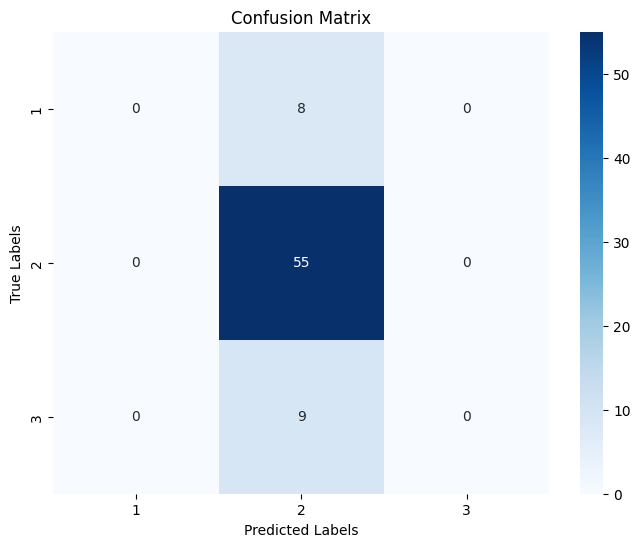

In [26]:
cm = confusion_matrix(truths, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(truths), yticklabels=np.unique(truths))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
f1_score(truths, preds, average='weighted')

0.6616360454943133